In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)

plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

훈련 데이터 크기: 10
훈련 데이터 크기: 100


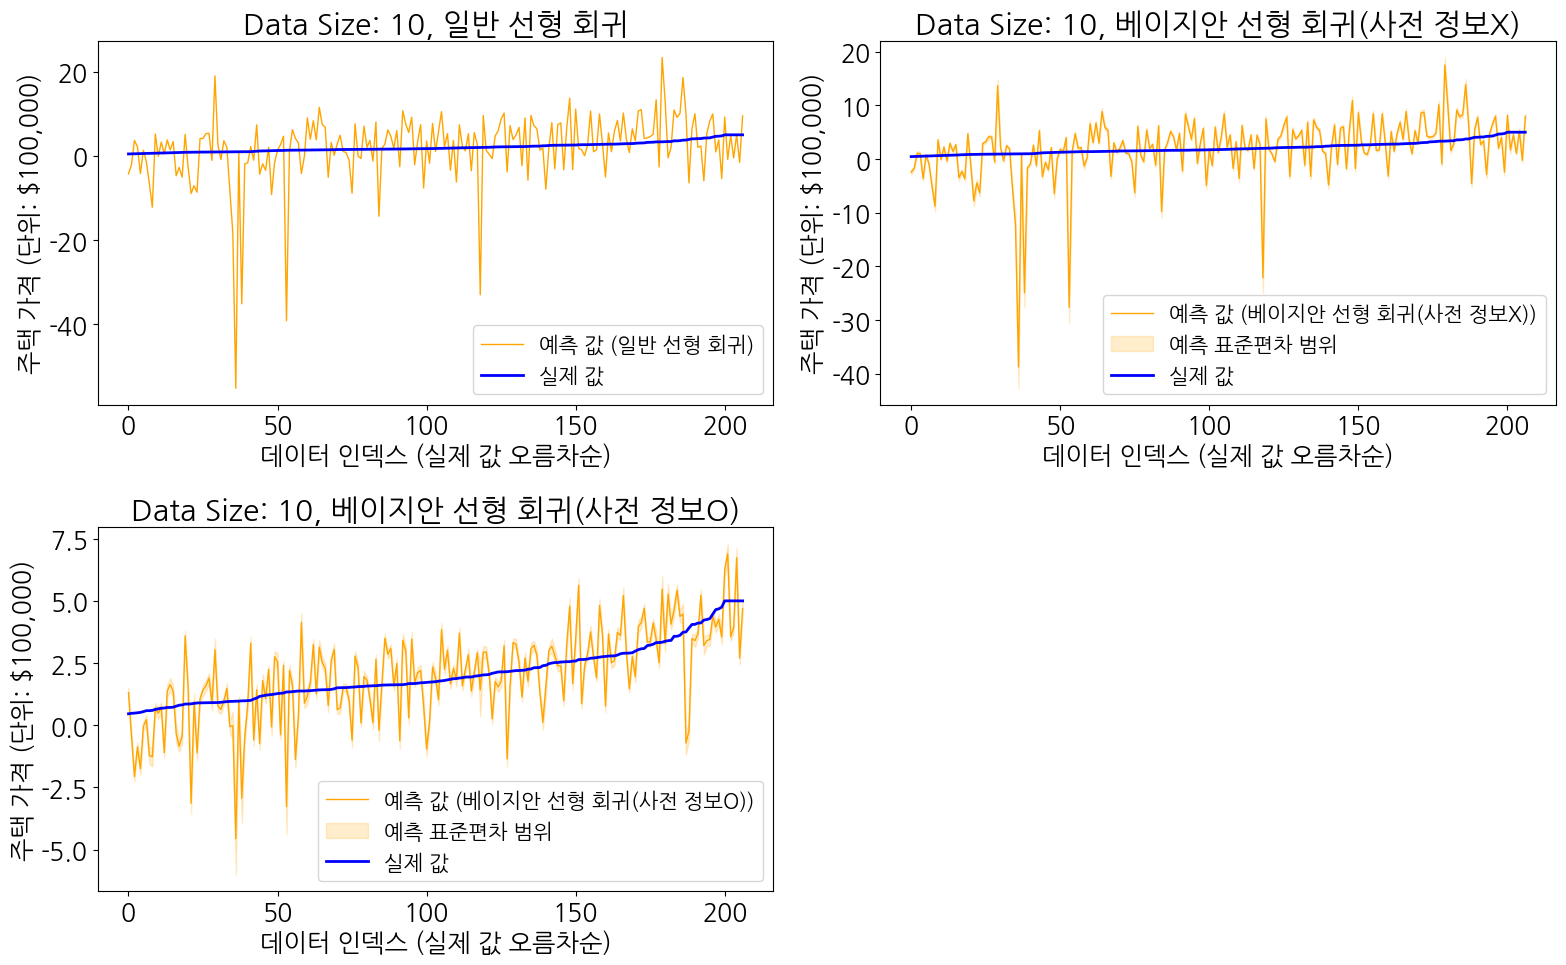

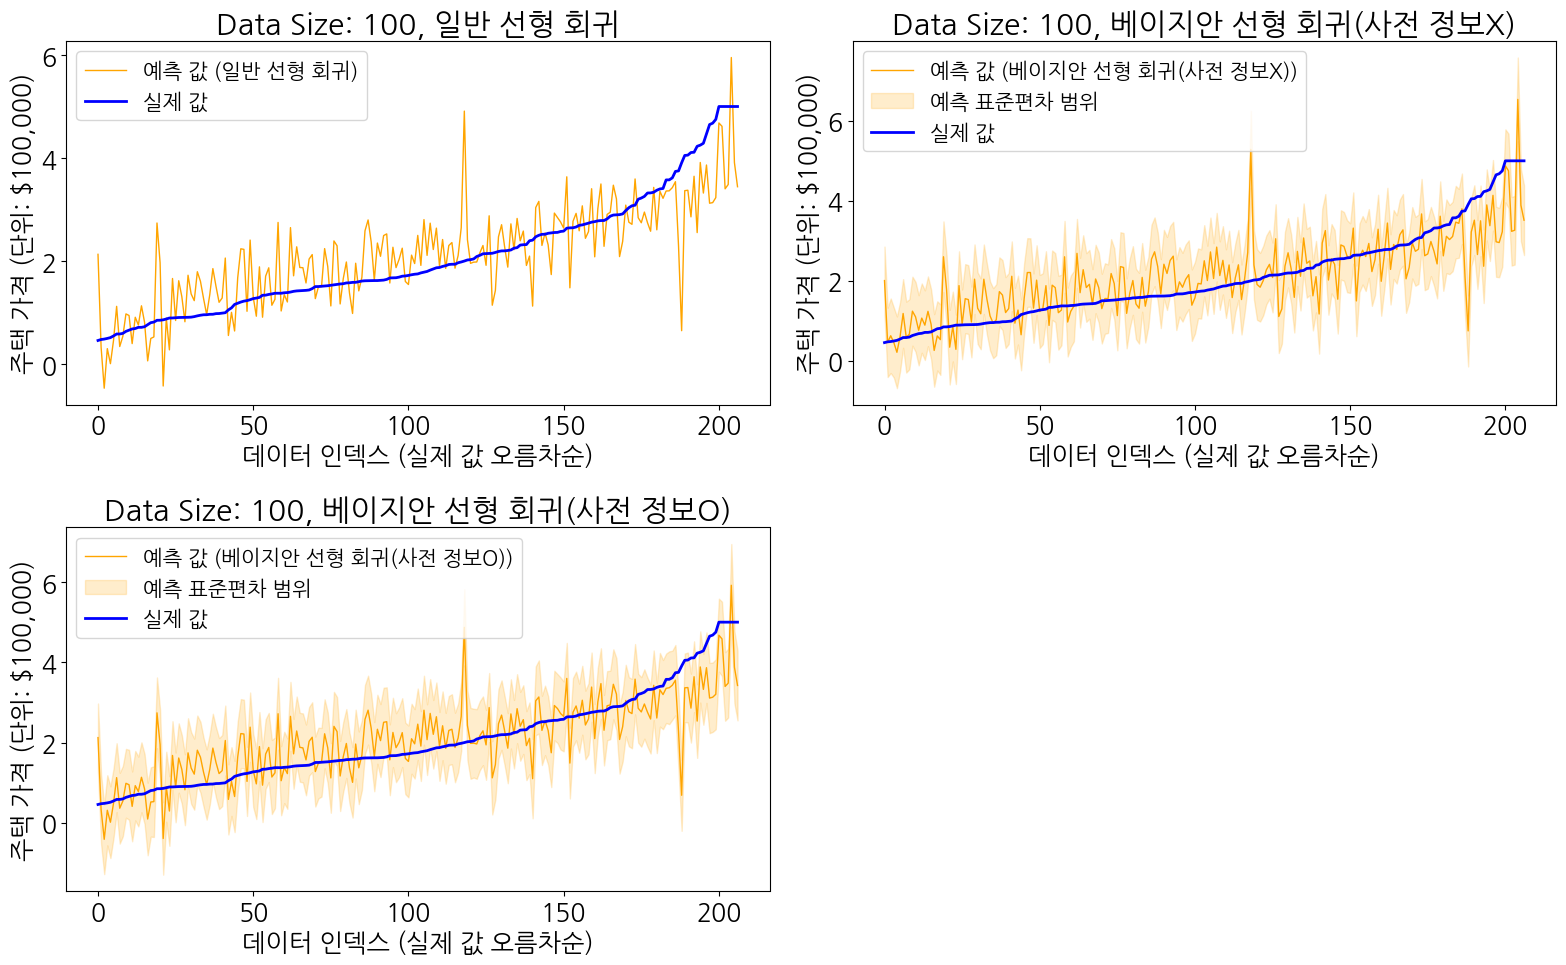

In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

california = fetch_california_housing()
X = california.data
y = california.target
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42)

train_sizes = [10, 100]
results = {}

X_test_with_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

X_test_with_bias_ols = X_test_with_bias
beta_test_ols = np.linalg.pinv(X_test_with_bias_ols) @ y_test

from sklearn.linear_model import LinearRegression

def ols_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def bayesian_regression_no_prior(X_train, y_train, X_test, sigma2):
    n_features = X_train.shape[1]
    mu_0 = np.zeros(n_features)
    sigma2_0 = 100
    V_0 = sigma2_0 * np.eye(n_features)
    V_n = np.linalg.inv(np.linalg.inv(V_0) + (1 / sigma2) * X_train.T @ X_train)
    mu_n = V_n @ ((1 / sigma2) * X_train.T @ y_train)
    y_pred = X_test @ mu_n
    y_pred_variance = np.array([X_test[i, :] @ V_n @ X_test[i, :].T + sigma2 for i in range(X_test.shape[0])])
    y_pred_std = np.sqrt(y_pred_variance)
    return y_pred, y_pred_std

def bayesian_regression_partial_test_prior(X_train, y_train, X_test, beta_test_ols, sigma2):
    n_features = X_train.shape[1]

    random_error = np.random.normal(0, 0.5 * np.abs(beta_test_ols))
    mu_0 = beta_test_ols + random_error

    sigma2_0 = 3
    V_0 = sigma2_0 * np.eye(n_features)

    V_n = np.linalg.inv(np.linalg.inv(V_0) + (1 / sigma2) * X_train.T @ X_train)
    mu_n = V_n @ (np.linalg.inv(V_0) @ mu_0 + (1 / sigma2) * X_train.T @ y_train)

    y_pred = X_test @ mu_n
    y_pred_variance = np.array([
        X_test[i, :] @ V_n @ X_test[i, :].T + sigma2
        for i in range(X_test.shape[0])
    ])
    y_pred_std = np.sqrt(y_pred_variance)

    return y_pred, y_pred_std

for size in train_sizes:
    print(f"훈련 데이터 크기: {size}")

    idx = np.random.choice(X_train_full.shape[0], size, replace=False)
    X_train = X_train_full[idx]
    y_train = y_train_full[idx]

    X_train_with_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

    beta_train_ols = np.linalg.pinv(X_train_with_bias) @ y_train

    y_train_pred = X_train_with_bias @ beta_train_ols
    residuals = y_train - y_train_pred
    sigma2 = np.var(residuals, ddof=X_train_with_bias.shape[1])

    results[size] = {
        '일반 선형 회귀': None,
        '베이지안 선형 회귀(사전 정보X)': None,
        '베이지안 선형 회귀(사전 정보O)': None,
    }

    y_pred_ols = ols_regression(X_train, y_train, X_test)
    results[size]['일반 선형 회귀'] = {'y_pred': y_pred_ols}

    y_pred_bayes_no_prior, y_pred_std_no_prior = bayesian_regression_no_prior(
        X_train_with_bias, y_train, X_test_with_bias, sigma2)
    results[size]['베이지안 선형 회귀(사전 정보X)'] = {
        'y_pred': y_pred_bayes_no_prior,
        'y_std': y_pred_std_no_prior
    }

    y_pred_bayes_partial_test_prior, y_pred_std_partial_test = bayesian_regression_partial_test_prior(
        X_train_with_bias, y_train, X_test_with_bias, beta_test_ols, sigma2)
    results[size]['베이지안 선형 회귀(사전 정보O)'] = {
        'y_pred': y_pred_bayes_partial_test_prior,
        'y_std': y_pred_std_partial_test
    }

for size in train_sizes:
    y_test_sorted_indices = np.argsort(y_test)
    y_test_sorted = y_test[y_test_sorted_indices]

    plt.figure(figsize=(16, 10))

    for i, (case_name, result_dict) in enumerate(results[size].items(), 1):
        y_pred = result_dict['y_pred']
        y_pred_sorted = y_pred[y_test_sorted_indices]

        plt.subplot(2, 2, i)

        plt.plot(y_pred_sorted, label=f'예측 값 ({case_name})', color='orange', linewidth=1)

        if 'y_std' in result_dict:
            y_std = result_dict['y_std']
            y_std_sorted = y_std[y_test_sorted_indices]
            plt.fill_between(np.arange(len(y_test_sorted)),
                             y_pred_sorted - y_std_sorted,
                             y_pred_sorted + y_std_sorted,
                             color='orange', alpha=0.2, label='예측 표준편차 범위')
        plt.plot(y_test_sorted, label='실제 값', color='blue', linewidth=2)
        plt.legend(fontsize=15)
        plt.title(f'Data Size: {size}, {case_name}')
        plt.xlabel('데이터 인덱스 (실제 값 오름차순)')
        plt.ylabel('주택 가격 (단위: $100,000)')

    plt.tight_layout()
    plt.show()